In [82]:
import numpy as np
import pandas as pd
import os
import sys

# Add the directory containing the VotingModel to the Python path
sys.path.append(os.path.abspath('/Users/idrees/Code/govxs/'))
from model.VotingRules import mean_aggregation, median_aggregation, quadratic_aggregation

from model.VotingModel import VotingModel

def simulate_bribery_mean(model, target_project, desired_increase):
    num_voters, num_projects = model.voting_matrix.shape
    new_voting_matrix = model.voting_matrix.copy()

    # Calculate the original allocation
    original_allocation = model.mean_aggregation()
    original_funds = original_allocation[target_project]
 

    # Calculate the target allocation
    target_funds = original_funds + desired_increase
    total_required_votes = target_funds * num_voters
 

    # Calculate the current votes for the target project
    current_votes = np.sum(new_voting_matrix[:, target_project])

    votes_needed = total_required_votes - current_votes

    bribery_cost = votes_needed
    
    return bribery_cost

def simulate_bribery_quadratic(model, target_project, desired_increase):
    num_voters, num_projects = model.voting_matrix.shape
    new_voting_matrix = model.voting_matrix.copy()

    # Calculate the original allocation
    original_allocation = model.quadratic_aggregation()
    original_funds = original_allocation[target_project]

    # Calculate the target allocation
    target_funds = original_funds + desired_increase
    total_required_votes = (target_funds * np.sum(original_allocation)) ** 0.5

    # Calculate the current votes for the target project
    current_votes = np.sum(new_voting_matrix[:, target_project] ** 2)
    votes_needed = total_required_votes - np.sqrt(current_votes)
    votes_needed = votes_needed ** 2

    bribery_cost = votes_needed
       
    return bribery_cost

def simulate_bribery_median(model, target_project, desired_increase):
    num_voters, num_projects = model.voting_matrix.shape
    new_voting_matrix = model.voting_matrix.copy()
    original_voting_matrix=new_voting_matrix

    # Calculate the original allocation
    original_allocation = model.median_aggregation()
    original_funds = original_allocation[target_project]

    # Calculate the target allocation
    target_funds = original_funds + desired_increase

    # Calculate the current median vote for the target project
    votes = new_voting_matrix[:, target_project]
    current_median_vote = np.median(votes)

    # Determine the new median vote required
    total_required_votes = target_funds * model.num_voters / model.total_op_tokens
    votes_needed = total_required_votes - current_median_vote

    # Calculate the bribery cost as the amount needed to change the median vote
    bribery_cost = desired_increase#np.abs(votes_needed) * model.total_op_tokens / model.num_voters

    return bribery_cost


def evaluate_bribery_impact(model, target_project, desired_increase):
    # Bribery impact for each aggregation method
    bribery_costs = {}
    for method in ["mean", "median", "quadratic"]:
        if method == "mean":
            bribery_cost = simulate_bribery_mean(model, target_project, desired_increase)
        elif method == "median":
            bribery_cost = simulate_bribery_median(model, target_project, desired_increase)
        elif method == "quadratic":
            bribery_cost = simulate_bribery_quadratic(model, target_project, desired_increase)
    
        bribery_costs[method + "_bribery_cost"] = bribery_cost

    return bribery_costs# Initialize the model

In [83]:
def run_simulation(num_rounds, num_voters, num_projects, total_op_tokens, max_bribe,voter_type):
    results = []
    desired_increases = np.linspace(max_bribe/num_rounds, max_bribe, num_rounds)

    for i in range(num_rounds):
        # Initialize the model
        model = VotingModel(voter_type=voter_type,num_voters=num_voters, num_projects=num_projects, total_op_tokens=total_op_tokens)
        data=model.step()

        # Set parameters for bribery evaluation
        target_project = np.random.randint(0, num_projects)  # Randomly select a target project
        desired_increase = desired_increases[i] # Randomly set a desired increase between 5K and 10K OP tokens

        # Evaluate the impact of bribery
        bribery_costs = evaluate_bribery_impact(model, target_project, desired_increase)

        result = {
            "round": i + 1,
            "target_project": target_project,
            "desired_increase": desired_increase,
            "mean_bribery_cost": bribery_costs.get("mean_bribery_cost"),
            "median_bribery_cost": bribery_costs.get("median_bribery_cost"),
            "quadratic_bribery_cost": bribery_costs.get("quadratic_bribery_cost")
        }

        results.append(result)

    # Create a DataFrame from the results
    final_results = pd.DataFrame(results)
    return final_results

# Parameters for multiple simulations
num_rounds = 100
num_voters = 100
num_projects = 500
total_op_tokens = 30e6
max_desired_fund_increase=1e6
voter_type='random_uniform_model'

# Run the simulations
final_results = run_simulation(num_rounds, num_voters, num_projects, total_op_tokens,max_desired_fund_increase,voter_type)

# Display the results
final_results

/Users/idrees/Code/govxs/agents/VoterAgent.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


,round,target_project,desired_increase,mean_bribery_cost,median_bribery_cost,quadratic_bribery_cost
0,1,103,10000.0,1000000.0,10000.0,4.909032e+11
1,2,458,20000.0,2000000.0,20000.0,6.003952e+11
2,3,30,30000.0,3000000.0,30000.0,6.984163e+11
3,4,391,40000.0,4000000.0,40000.0,8.732981e+11
4,5,176,50000.0,5000000.0,50000.0,7.927669e+11
...,...,...,...,...,...,...
95,96,441,960000.0,96000000.0,960000.0,2.238069e+13
96,97,28,970000.0,97000000.0,970000.0,2.147367e+13
97,98,347,980000.0,98000000.0,980000.0,2.412358e+13
98,99,59,990000.0,99000000.0,990000.0,2.291708e+13


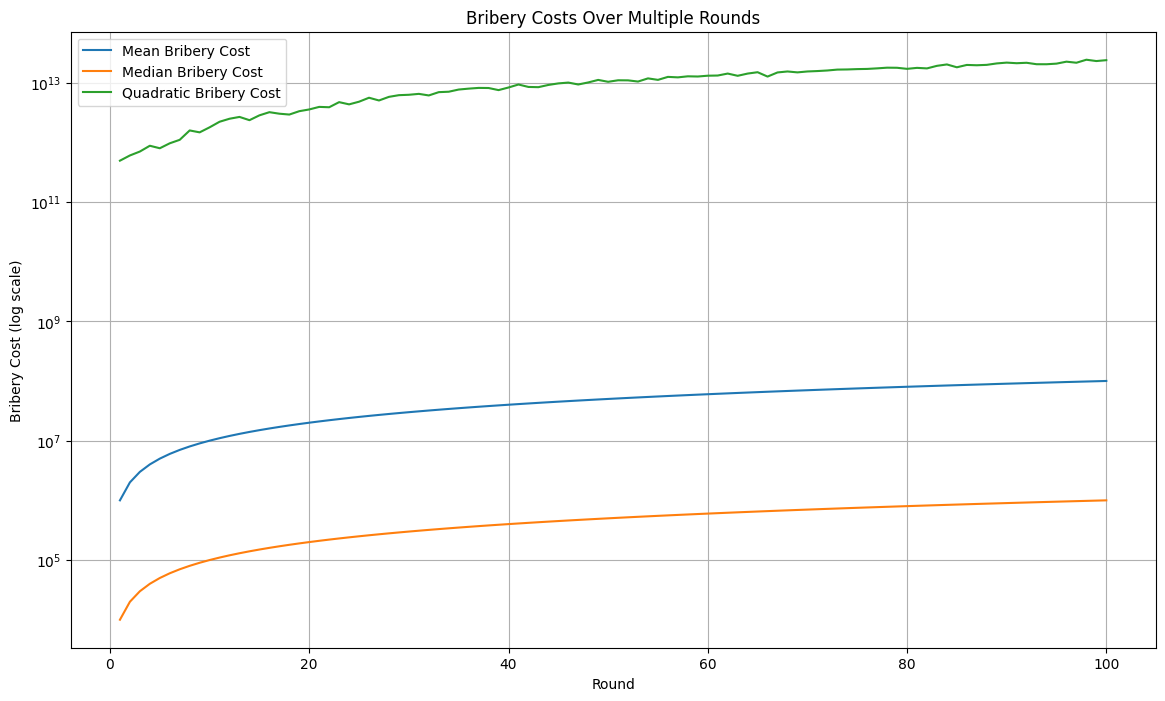

In [84]:
import matplotlib.pyplot as plt

# Plot the results with a logarithmic y-axis
def plot_bribery_costs(df):
    plt.figure(figsize=(14, 8))

    # Plot mean bribery cost
    plt.plot(df['round'], df['mean_bribery_cost'], label='Mean Bribery Cost')

    # Plot median bribery cost
    plt.plot(df['round'], df['median_bribery_cost'], label='Median Bribery Cost')

    # Plot quadratic bribery cost
    plt.plot(df['round'], df['quadratic_bribery_cost'], label='Quadratic Bribery Cost')

    plt.xlabel('Round')
    plt.ylabel('Bribery Cost (log scale)')
    plt.yscale('log')
    plt.title('Bribery Costs Over Multiple Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the bribery costs
plot_bribery_costs(final_results)

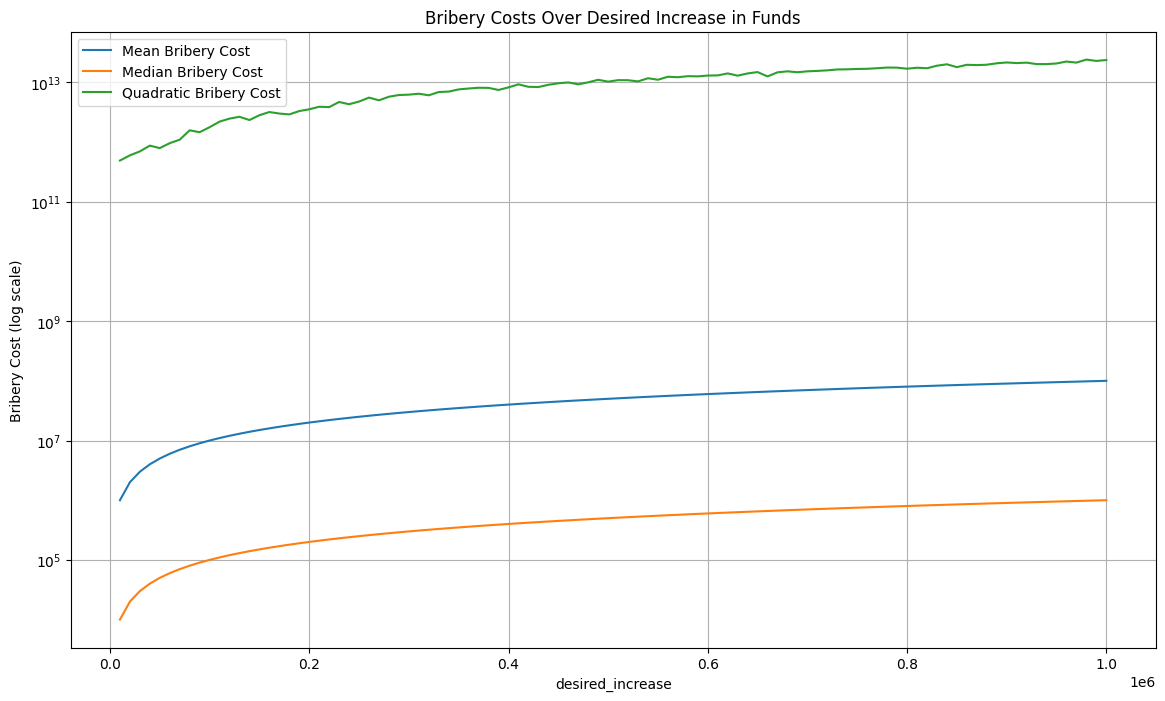

In [85]:
def plot_bribery_costs(df):
    plt.figure(figsize=(14, 8))

    # Plot mean bribery cost
    plt.plot(df['desired_increase'], df['mean_bribery_cost'], label='Mean Bribery Cost')

    # Plot median bribery cost
    plt.plot(df['desired_increase'], df['median_bribery_cost'], label='Median Bribery Cost')

    # Plot quadratic bribery cost
    plt.plot(df['desired_increase'], df['quadratic_bribery_cost'], label='Quadratic Bribery Cost')

    plt.xlabel('desired_increase')
    plt.ylabel('Bribery Cost (log scale)')
    plt.yscale('log')
    plt.title('Bribery Costs Over Desired Increase in Funds')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the bribery costs
plot_bribery_costs(final_results)

In [86]:
summary_stats = final_results[['mean_bribery_cost', 'median_bribery_cost', 'quadratic_bribery_cost']].describe()
print(summary_stats)

       mean_bribery_cost  median_bribery_cost  quadratic_bribery_cost
count       1.000000e+02           100.000000            1.000000e+02
mean        5.050000e+07        505000.000000            1.098615e+13
std         2.901149e+07        290114.919759            6.788104e+12
min         1.000000e+06         10000.000000            4.909032e+11
25%         2.575000e+07        257500.000000            4.950045e+12
50%         5.050000e+07        505000.000000            1.063697e+13
75%         7.525000e+07        752500.000000            1.682574e+13
max         1.000000e+08       1000000.000000            2.412358e+13


In [80]:
from scipy import stats

mean_costs = final_results['mean_bribery_cost']
median_costs = final_results['median_bribery_cost']
quadratic_costs = final_results['quadratic_bribery_cost']

# Perform paired t-tests
t_test_mean_median = stats.ttest_rel(mean_costs, median_costs)
t_test_mean_quadratic = stats.ttest_rel(mean_costs, quadratic_costs)
t_test_median_quadratic = stats.ttest_rel(median_costs, quadratic_costs)

print("Paired t-test between Mean and Median Bribery Costs:", t_test_mean_median)
print("Paired t-test between Mean and Quadratic Bribery Costs:", t_test_mean_quadratic)
print("Paired t-test between Median and Quadratic Bribery Costs:", t_test_median_quadratic)


Paired t-test between Mean and Median Bribery Costs: TtestResult(statistic=np.float64(-68.70931305072087), pvalue=np.float64(2.4026531651481654e-85), df=np.int64(99))
Paired t-test between Mean and Quadratic Bribery Costs: TtestResult(statistic=np.float64(-16.12360258486829), pvalue=np.float64(1.9054622725889808e-29), df=np.int64(99))
Paired t-test between Median and Quadratic Bribery Costs: TtestResult(statistic=np.float64(-16.10593176625294), pvalue=np.float64(2.0618742895811592e-29), df=np.int64(99))
